###Capstone Project III

In [0]:
#from __future__ import print_function
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import imdb
import numpy as np
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from os import listdir

### Load Data
In loading the data I specified 10000 features which is the amount of distinct words allowed. The dataset is also set up with the training and test data already determined and split into 25000 samples each.

In [0]:
# The number of distinct words allowed. I chose 10000
num_words = 10000
# Set the training and testing data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

In [0]:
# THIS BLOCK OF CODE WAS COMMENTED OUT AS I HAD PROBLEMS LOADING THE DATASET.
# THERE WAS A PROBLEM WITH THE PICKLE STATEMENT AND THE BELOW WAS UTILISED TO
# BYPASS IT. IT SEEMS THE ISSUE WAS RESOLVED BY KERAS AND TENSORFLOW.
# # number of features to be used in the num_word argument in the load_data method
# num_words = 5000
# # save np.load
# np_load_old = np.load

# # # # modify the default parameters of np.load
# # # #allow_pickle=True,
# np.load = lambda *a, **k: np_load_old(*a,allow_pickle=True,  **k)

# # # call load_data with allow_pickle implicitly set to true
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# # # # restore np.load for future normal usage
# np.load = np_load_old

### Explore Data
In exploring the data as suggested in the task pdf, I looked at the words in the sixth review of the training dataset.

In [0]:
# create and instance that contains the words in the word index
word2_id = imdb.get_word_index()
# Now using a for loop that accesses the items in the index one by one, we assign them all
# to a variable.
id2word = {i: word for word, i in word2_id.items()}
# Here we print the words contained in the sixth review in the dataset.
print([id2word.get(i, '') for i in x_train[6]])

['the', 'boiled', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'murdering', 'naschy', 'br', 'villain', 'and', 'suggestion', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'and', 'concentrates', 'concept', 'issue', 'skeptical', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'starship', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'originals', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'dose', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because', 'many', 'br', 'of', 'overly', 'to', 'descen

### Pre-processing the data
Here I need to note something. The pdf suggested that a length of 500 words should be utilsed for this task. My experience brought me to a place that no matter how I tried to tweak the parameters of my model, I could not get a better result than 50% accuracy on my test evaluation. This is extremely poor and so, through trial and error I found 200 to be a good measure for getting decent results for this task. Even 230 words still did not yield good results. See model 2 with a single LSTM layer.<br>
It is also important to note that I utilised 5000 features at first for my num_words variable but found that it generated too little parameters to yield good results. Anyhow...let's limit and pad the reviews.

In [0]:
# Set the maximum length for each review
max_len = 200
# Pre-process the training and test data with the pad_sequences method. I chose 'post' padding here as I want
# the algorithm to process the endcoded words first.
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len, dtype='int32', padding='post', 
                                                     truncating='post', value=0.0)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len, dtype='int32', padding='post', 
                                                     truncating='post', value=0.0)

After the pre-processing I was curious to see in what shape the data was, so below just a couple of exlorations on the newly shaped data :)

In [0]:
# Print a couple of instances
print(len(x_train[6000]))
print(len(x_test[6000]))
print(y_train[6000])
print(y_test)

200
200
0
[0 1 1 ... 0 0 0]


In [0]:
# Our training length is now set at 200 words.
len(x_train[24999])

200

In [0]:
# The shape of the training data shows how the pad_sequences method worked its magic.
x_train.shape

(25000, 200)

In [0]:
# Our test data is also now in the correct shape for validation.
x_test.shape

(25000, 200)

### Build Model
For this task I decided to construct two types of RNN models. A single LSTM layer RNN and a multi LSTM layer RNN.
### Single LSTM layer RNN
The first function I have created constructed a model with a single LSTM layer and a preceding embedding layer and as final layer, a dense layer.

In [0]:
def build_run_model(model, numWords, output, inputLength, batch_size, epochs):
    '''This function constructs a single LSTM layer RNN training and evaluation model.
    It prints out a summary of the constructed model as well as each training epoch 
    with training and val loss and test scores.

    The arguments received for this function are as follows;
    a) model - Just a string with the model number.
    b) numWords - This corresponds to the same number as the num_words
       argument when the data is loaded.
    c) output - This is the number of neurons we want from the Embedding to the
       first LSTM layer.
    d) inputLength - This parameter corresponds to the max_len variable which is where
       we limited (with the pad_sequences method) the amount of words in the review
       of each movie.
    e) batch_size - This is the amount of instances processed at a time in each epoch
       untill the 25000 training and testing instances are covered.
    f) epochs - The amount of times the 25000 training and testing instances will be
       processed with the batch size.'''
    
    # ===================
    # CONSTRUCT THE MODEL
    # ===================
    # Construct the model with a single LSTM layer
    model = Sequential()
    model.add(Embedding(numWords, output, input_length=inputLength))
    model.add(LSTM(output, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Print out a summary of the model
    model.summary()
    # Compile the model and set the loss, optimizer and metrics parameters
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # Fit the model and print the evaluation results
    
    # ===============
    # TRAIN THE MODEL
    # ===============
    print('Train...')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test))
    
    # ==================
    # EVALUATE THE MODEL
    # ==================
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)

#### Model 1

With a batch size of 128 and 10 epochs this model trained and tested very close to the best model (Model 2 - Multi LSTM Layer) I have created. With a Training accuracy 89.9% and Testing accuracy of 84.776% I must be honest I was looking for something a little better. So I tried...

In [0]:
# num_words = 10000, max_len = 200, LSTM output = 125, batch size = 128, epochs = 10
build_run_model('model1', num_words, 125, max_len, 128, 10)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 125)          1250000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 125)               125500    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 126       
Total params: 1,375,626
Trainable params: 1,375,626
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 130s 5ms/sample - loss: 0.6778 - accuracy: 0.5590 - val_loss: 0.5943 - val_accuracy: 0.7250
Epoch 2/10
25000/25000 [==============================] - 131s 5ms/sample - loss: 0.6232 - accuracy: 0.6594 - val_loss: 0.5889 - val_accuracy: 0.6919
Epoch 3/10
2500

#### Model 2
With this model I just wanted to show what I have experienced for the first couple of models that I have constructed. With a maximum length of 230 I could not achieve better results than 50% accuracy. This was the case for many lengths that I have tried from 500 downwards.

In [0]:
# num_words = 10000, max_len = 230, LSTM ouput = 125, batch size = 128, epochs = 10
build_run_model('model1', num_words, 125, max_len, 128, 10)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 230, 125)          1250000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 125)               125500    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 126       
Total params: 1,375,626
Trainable params: 1,375,626
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 154s 6ms/sample - loss: 0.6936 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
25000/25000 [==============================] - 152s 6ms/sample - loss: 0.6934 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
2500

#### Model 3
A classic example of overfitting where the training scores are great at 99.9% for accuracy and 0.2 for loss respectively but the testing accuracy and loss not converging. The loss for testing, for example, climbed to a crazy value of 1.22.

In [0]:
# max_len = 200, output of LSTM = 125, max_words = 10000, batch size = 25, epochs = 25
build_run_model('model1', num_words, 125, max_len, 25, 25)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 125)          1250000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 125)               125500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 126       
Total params: 1,375,626
Trainable params: 1,375,626
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/25
25000/25000 [==============================] - 233s 9ms/sample - loss: 0.6780 - accuracy: 0.5586 - val_loss: 0.6965 - val_accuracy: 0.5049
Epoch 2/25
25000/25000 [==============================] - 227s 9ms/sample - loss: 0.6121 - accuracy: 0.6627 - val_loss: 0.5457 - val_accuracy: 0.7503
Epoch 3/25
2500

### Multi LSTM layer RNN
The below function might be big but I needed to get all the functionality into it to prevent me from creating lengthy models and repetitive code. It delivers all the needed outputs required for the training, testing and evaluation of the dataset as well as the predicting required for the task to see if the model delivers results.
Please bare with me ;)

In [0]:
def build_run_model_mul(model, numWords, output, lstm2_out, inputLength, batch_size, epochs):
    '''This function builds a multi LSTM layer Recurrent Neural Network training and testing model.
    It also does the following:
    1) It prints the model evaluation score and accuracy.
    2) It plots the training history per epoch. This history is
    plotted as training over validation loss.
    3) It makes two predictions utilising the model. If the value of the prediction result is greater
    than 0.5, then it is a positive review. If less than, then it is a negative review. For the predictions, 
    I created two reviews assigned to two variables in the function.
    
    The arguments received for this function are as follows;
    a) model - Just a string with the model number.
    b) numWords - This corresponds to the same number as the num_words
       argument when the data is loaded.
    c) output - This is the number of neurons we want from the Embedding to the
       first LSTM layer.
    d) lstm2_out - The amount of neurons in the second LSTM layer to our Dense layer
    e) inputLength - This parameter corresponds to the max_len variable which is where
       we limited (with the pad_sequences method) the amount of words in the review
       of each movie.
    f) batch_size - This is the amount of instances processed at a time in each epoch
       untill the 25000 training and testing instances are covered.
    g) epochs - The amount of times the 25000 training and testing instances will be
       processed with the batch size.
    '''
    # ===================
    # CONSTRUCT THE MODEL
    # ===================
    model = Sequential()
    model.add(Embedding(numWords, output, input_length=inputLength))
    # After the Embedding layer add the two LSTM layers
    # For the first LSTM layer the return sequences must be set to True
    # An input shape is also required and here, it is set to (2, 1) to fit to the data.
    model.add(LSTM(output, dropout=0.2, recurrent_dropout=0.2,
                   return_sequences=True, input_shape=(2, 1)))
    model.add(LSTM(lstm2_out, dropout=0.2, recurrent_dropout=0.2))
    # After the LSTM layers we add a Dense layer with sigmoid activation.
    model.add(Dense(1, activation='sigmoid'))
    # Here we print the model summary
    model.summary()
    # Compile the model with the loss, optimizer and metrics set appropriately
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # ===============
    # TRAIN THE MODEL
    # ===============
    print('Train...')
    # set the model.fit function to a variable for plotting later on.
    # The relevant parameters here besides the training and validation data
    # is set when the function is called, i.e. epochs & batch_size
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))
    # set the model.evalation function to two variables
    # and print the score and accuracy
    
    # ==================
    # EVALUATE THE MODEL
    # ==================
    score, acc = model.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    # Plot the model training and evalution history
    # for analysis.
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # =================
    # MAKE A PREDICTION
    # =================
    # Here we will make to predictions with the model trained. One 1) negative review and one 2) positive review
    print("Making a prediction on the following reviews:")
    print("1) The movie was a great waste of my time. The storyline didn't catch my attention or interest")
    print("2) That was one of the better movies I have seen this year. I loved the plot and thoroughly enjoyed the action.")
    # creaate an instance of the word index
    word_index = keras.datasets.imdb.get_word_index()
    # assign the review to variable, split the words in the sentence.
    review1 = "the movie was a great waste of my time. The storyline didn't catch my attention or interest"
    words1 = review1.split()
    review1 = []
    # create a for loop that checks whether the words in the review are in the index, if not, give a number two
    # to the word and append it to the review list. Keras established this to be the number value
    # for words not in the index. The else conditional takes the words in the review that are in the word index
    # and assign to it the relevant number. The +3 is to offset for the first four numbers allocated to special
    # values by Keras.
    for word in words1:
        if word not in word_index:
            review1.append(2)
        else:
            review1.append(word_index[word]+3)
    review1 = keras.preprocessing.sequence.pad_sequences([review1],
                                                         truncating='post', padding='post', maxlen=max_len)
    prediction1 = model.predict(review1)
    print("Prediction 1 (0 = negative, 1 = positive) = ", end="")
    print("%0.4f" % prediction1[0][0])
    # The same comments that apply to review1 applies to review2
    review2 = "That was one of the better movies I have seen this year. I loved the plot and thoroughly enjoyed the action"
    words2 = review2.split()
    review2 = []
    for word in words2:
        if word not in word_index:
            review2.append(2)
        else:
            review2.append(word_index[word]+3)
    review2 = keras.preprocessing.sequence.pad_sequences([review2],
                                                         truncating='post', padding='post', maxlen=max_len)
    prediction2 = model.predict(review2)
    print("Prediction 2 (0 = negative, 1 = positive) = ", end="")
    print("%0.4f" % prediction2[0][0])

#### Model 1
The first multi LSTM layer model displays underfitting as we did not train the model with enough epochs so the data did not have enough time to converge. It was good however to test all the parameters for the function :)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 50)           500000    
_________________________________________________________________
lstm_22 (LSTM)               (None, 200, 50)           20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 527,826
Trainable params: 527,826
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 101s 4ms/sample - loss: 0.6937 - accuracy: 0.5132 - val_loss: 0.6891 - val_accuracy: 0.5528
Epoch 2/2
25000/25000 [==============

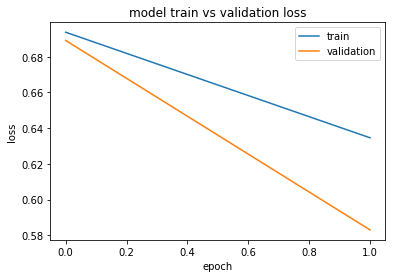

Making a prediction on the following reviews:
1) The movie was a great waste of my time. The storyline didn't catch my attention or interest
2) That was one of the better movies I have seen this year. I loved the plot and thoroughly enjoyed the action.
Prediction 1 (0 = negative, 1 = positive) = 0.2590
Prediction 2 (0 = negative, 1 = positive) = 0.6659


In [0]:
# num_words = 10000, max_len = 200, 50 outputs on the first LSTM and 25 on the next. Batch size = 100, epochs = 2
build_run_model_mul('model3', num_words, 50, 25, max_len, 100, 2)

#### Model 2
My best effort for this task! This model with 100 outputs in the first LSTM layer, 25 in the next, a batch size of 100 and 11 epochs, delivered for me acceptable results for this task. The training and testing losses did not converge completely but the predictions speak for itself. By utilising a highly positive and highly negative review created myself, the model managed to predict maximum results for a positive and a negative review. These resulted to values of 0.85 and 0.04 respectively. For analysis, if the prediction is greater than 0.5, then it is positive, if less than, then it is negative. <br>I loved doing this task and I will probably learn more on how to optimize parameters to achieve state of the art performance in the near future. I hope you enjoyed this with me!!! Stay well.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 25)                12600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,093,026
Trainable params: 1,093,026
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/11
25000/25000 [==============================] - 161s 6ms/sample - loss: 0.6815 - accuracy: 0.5484 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 2/11
25000/25000 [=========

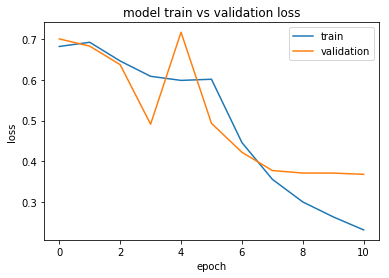

Making a prediction on the following reviews:
1) The movie was a great waste of my time. The storyline didn't catch my attention or interest
2) That was one of the better movies I have seen this year. I loved the plot and thoroughly enjoyed the action.
Prediction 1 (0 = negative, 1 = positive) = 0.0401
Prediction 2 (0 = negative, 1 = positive) = 0.8512


In [0]:
# num_words = 10000, max_len = 200
build_run_model_mul('model5', num_words, 100, 25, max_len, 100, 11)